# Graph-to-Combinatorial Probabilistic Clique Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [6]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [7]:
dataset_name = "manual_cliques_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_cliques_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual_cliques',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


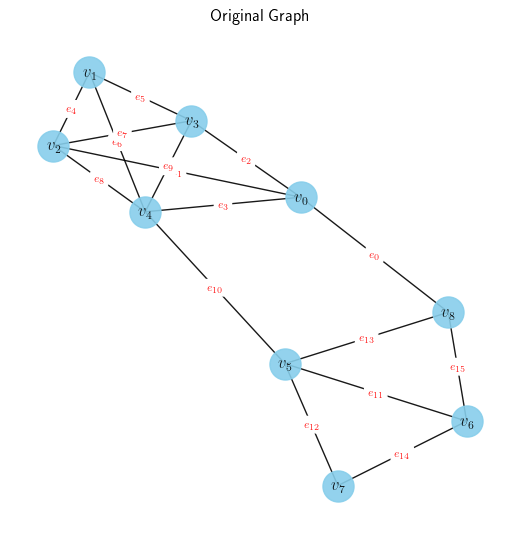

 - Graph with 9 vertices and 16 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [8]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data.

We introduce a probabilistic version of the clique lifting. This lifting is appropriate under the assumption that some edges have been randomly and uniformly erased from the graph.
The algorithm does **not** introduce extra edges to the complex, and the probabilistic part is only involved in adding higher-order cells.

The algorithm finds the cliques $C_{i,j}$ of size $i$, and considers nodes which are highly connected to the clique. Given a probability parameter $p=$`probability` representing the erasure probability (assuming independence of erasures), it considers a node $x$ as part of a clique $C_{i,j}$ if

$$|N(x)\cap C_{i,j}| \ge (1-p)|C_{i,j}|$$

It does so iteratively, by adding the missing edges from $x$ to $C_{i,j}$ to an auxiliary graph, re-identifying the cliques, and adding the corresponding cells of dimension $i$ or greater.

The backbone of the algorithm is the method `nx.find_cliques`, which uses the Bron-Kerbosch algorithm [[2]](https://dl.acm.org/doi/10.1145/362342.362367), which has complexity $O(3^{n/3})$ where $n$ is the number of nodes. Reidentifying the cliques for each clique size may seem computationally expensive, but due to the nature of the Bron-Kerbosch algorithm this is faster than expanding the existing cliques naively, and has complexity $O(k3^{n/3})$, where $k$ is the maximum clique size in the original graph.

***
[[1]](https://dl.acm.org/doi/10.1145/362342.362367) Bron, C. and Kerbosch, J. (1973) Algorithm 457: finding all cliques of an undirected graph.
***


In [9]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2combinatorial/probabilistic_clique_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2combinatorial/probabilistic_clique_lifting:

{'transform_type': 'lifting',
 'transform_name': 'ProbabilisticCliqueLifting',
 'max_cell_length': None,
 'preserve_edge_attr': False,
 'feature_lifting': 'ProjectionSum',
 'probability': 0.3}


For the purposes of illustration, we set `probability`$=0.3$. We then apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /home/alvaro/Documents/ML/PCL/challenge-icml-2024/datasets/graph/toy_dataset/manual_cliques/lifting/4115556383

Dataset only contains 1 sample:


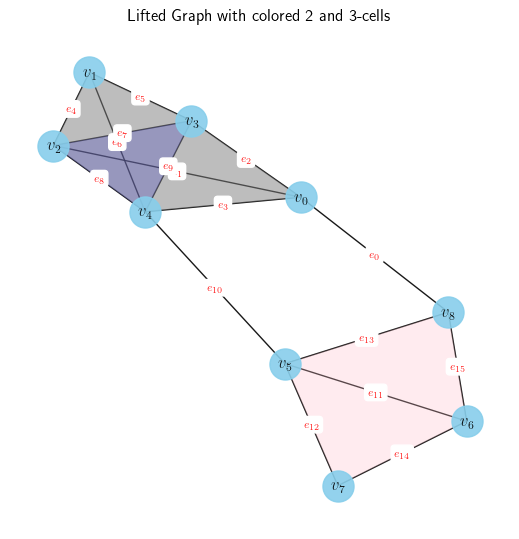

 - The complex has 9 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 16 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 9 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 2 3-cells.
 - The 3-cells have features dimension 1
 - The complex has 1 4-cells.
 - The 4-cells have features dimension 1



In [10]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

### Key features and comparison for different values of `probability`

In comparison with the clique lifting, the Probabilistic Clique Lifting produces **fewer, larger maximal cliques** (or cells) which overlap less with each other.

The lifting leverages the property of combinatorial complexes (as opposed to simplicial complexes, see [[2]](https://arxiv.org/pdf/2206.00606)) that not all subcells of a cell must be in the complex.

To get a sense of the effect of the `probability` parameter, here are some examples:

#### `probability`$=0$

In this case, we get the usual clique lifting: the maximal cliques are $\{0,2,3,4\}$, $\{1,2,3,4\}$ as well as $\{5,6,7\}$, $\{5,6,8\}$.

#### `probability`$=0.3$

The case above: the maximal cliques are $\{0,1,2,3,4\}$ as well as $\{5,6,7\}$, $\{5,6,8\}$.

#### `probability`$=0.4$

Cliques are clustered together more: the maximal cliques are $\{0,1,2,3,4\}$ as well as $\{5,6,7,8\}$.

#### `probability`$=1$

The most extreme case: the maximal clique is $\{0,1,2,3,4,5,6,7,8\}$.

***
[[2]](https://arxiv.org/pdf/2206.00606) Hajij, M., Zamzmi, G., Papamarkou, T., Miolane, N., Guzmán-Sáenz, A., Natesan Ramamurthy, K., Birdal, T., Dey, T., Mukherjee, S., Samaga, S., Livesay, N., Walters, R., Rosen, P., & Schaub, M. (2023). Topological deep learning: Going beyond graph data.
***

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [39]:
from modules.models.combinatorial.hmc import HMCModel

model_type = "combinatorial"
model_id = "hmc"
model_config = load_model_config(model_type, model_id)

model = HMCModel(model_config, dataset_config)


Model configuration for combinatorial HMC:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'negative_slope': 0.2}


In [40]:
y_hat = model(lifted_dataset.get(0))

/home/alvaro/Documents/ML/PCL/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  A_p = torch.sparse.mm(A_p, neighborhood)


If everything is correct the cell above should execute without errors. 